In [1]:
import os
import glob

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import  mapping #shape, 
import rasterio
# from rasterio.mask import mask
from rasterio.features import geometry_mask
from contextlib import contextmanager

from osgeo import gdal #, osr, ogr

In [2]:
# @contextmanager
# def open_tiff_file(filepath):
#     with rasterio.open(filepath) as src:
#         array = src.read(1)
#         no_data_value = src.nodata
#         if no_data_value is not None:
#             array = np.where(array == no_data_value, 0, array)
#         yield array
# def get_unit_codes(root_folder):
#     unit_codes = []
#     for subfolder in os.listdir(root_folder):
#         subfolder_path = os.path.join(root_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             for tiff_file in os.listdir(subfolder_path):
#                 if tiff_file.endswith('.tif'):
#                     unit_codes.append(int(tiff_file[:-4]))
                    
                
#     # return sorted(unit_codes)

# def read_tiff_file(subfolder_path, unit_code):
#     tiff_file = f"{unit_code}.tif"
#     tiff_file_path = os.path.join(subfolder_path, tiff_file)
#     if os.path.exists(tiff_file_path):
#         with open_tiff_file(tiff_file_path) as array:
#             array = np.where(np.logical_or(np.isnan(array), np.isinf(array)), 0, array)
#             return array
#     else:
#         return None


# def read_tiff_file0(tiff_file_path):
#     # tiff_file = f"{unit_code}.tif"
#     # tiff_file_path = os.path.join(subfolder_path, tiff_file)
#     if os.path.exists(tiff_file_path):
#         with open_tiff_file(tiff_file_path) as array:
#             array = np.where(np.logical_or(np.isnan(array), np.isinf(array)), 0, array)
#             return array
#     else:
#         return None

def createList(r1, r2):
    # Create a list of the months betweeen planting and maturity
    return np.arange(r1, r2+1)

def getListcom(p, m):
    # check if planting and maturity are in the same year
    if np.any(p < m):
        return createList(p, m)
    else:
        return np.concatenate((createList(p, 12), createList(1, m)))

In [28]:
# cCropCal = pd.read_csv("step1/hypothetical_ccc3.csv")
cCropCal = pd.read_csv("../data/CropCalender/2000_ir.csv")

cCropCal

,Country,State,District,unit_code,Crop,Subcrop,Type,Growing_area,Planting_Month,Maturity_Month
0,India,Andaman and Nicobar,Nicobar,3560001,Barley,1,Annual,0,7,11
1,India,Andaman and Nicobar,North & Middle Andaman,3560002,Barley,1,Annual,0,7,11
2,India,Andaman and Nicobar,South Andaman,3560003,Barley,1,Annual,0,7,11
3,India,Andhra Pradesh,Adilabad,3560004,Barley,1,Annual,0,7,11
4,India,Andhra Pradesh,Anantapur,3560005,Barley,1,Annual,0,7,11
...,...,...,...,...,...,...,...,...,...,...
16830,India,Uttarakhand,Pithoragarh,3560618,Rice3,3,Annual,1498,12,3
16831,India,Uttarakhand,Rudraprayag,3560619,Rice3,3,Annual,948,12,3
16832,India,Uttarakhand,Tehri Garhwal,3560620,Rice3,3,Annual,3032,12,3
16833,India,Uttarakhand,Udham Singh Nagar,3560621,Rice3,3,Annual,32259,12,3


In [29]:
# rank each by crop area in each unit code
def rank_crops(df_area):
#     print(df_area)
    df_area = df_area.sort_values('Growing_area', ascending=False)
    df_area['rank'] = range(1, len(df_area) + 1)
#     print(df_area)
    return df_area.set_index('rank')
    
ranked_df = cCropCal.sort_values(['unit_code', 'Crop']) \
    .groupby('unit_code') \
    .apply(rank_crops) \
    .reset_index(level=0, drop=True) \
    .reset_index() \
    .sort_values(['unit_code', 'rank'], ignore_index=True)

ranked_df


/tmp/ipykernel_381/1745104835.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rank_crops) \


,rank,Country,State,District,unit_code,Crop,Subcrop,Type,Growing_area,Planting_Month,Maturity_Month
0,1,India,Andaman and Nicobar,Nicobar,3560001,Barley,1,Annual,0,7,11
1,2,India,Andaman and Nicobar,Nicobar,3560001,Cassava,1,Annual,0,11,3
2,3,India,Andaman and Nicobar,Nicobar,3560001,Wheat1,1,Annual,0,12,4
3,4,India,Andaman and Nicobar,Nicobar,3560001,Sunflower,1,Annual,0,7,11
4,5,India,Andaman and Nicobar,Nicobar,3560001,Sugar cane,1,Perennial,0,1,12
...,...,...,...,...,...,...,...,...,...,...,...
16830,22,India,West Bengal,Uttar Dinajpur,3560641,Fodder,1,Fodder,0,1,12
16831,23,India,West Bengal,Uttar Dinajpur,3560641,Cotton,1,Annual,0,10,7
16832,24,India,West Bengal,Uttar Dinajpur,3560641,Coffee,1,Perennial,0,1,12
16833,25,India,West Bengal,Uttar Dinajpur,3560641,Cocoa,1,Perennial,0,1,12


In [30]:
raster_folder = "../data/Ras_shape_out/Rasters"
AEI = '../data/Ras_shape_out/Rasters/AEI/AEI_10.tif'
Area = '../data/Ras_shape_out/Rasters/Area/ara_10.tif'
AH = '../data/Ras_shape_out/Rasters/AH'

# ROOT FOLDER CONTAINS SHOULD CONTAIN CROP SUBFOLDERS WITH CLIPPED AREAS TIFF
root_folder = "data/Clipped_2000"

# Load the unit code files
tiff_files = glob.glob("{}/**/*.tif".format(raster_folder), recursive=True)
tiff_files
# # CLE crop land extent

# Load the unit code files
tiff_files = glob.glob("{}/**/*.nc4".format(raster_folder), recursive=True)
tiff_files

['../data/Ras_shape_out/Rasters/CC/bar_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/bar_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/bea_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/bea_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cas_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cas_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cot_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cot_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mai_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mai_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mil_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mil_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rast

In [31]:
dataset = gdal.Open("../data/Clipped_2000/AEI_00/3560001.tif", gdal.GA_ReadOnly)

In [32]:
dataset.RasterXSize, dataset.RasterYSize, dataset.RasterCount, dataset.GetRasterBand(1)

(20,
 83,
 1,
 <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7ff0f53f56b0> >)

In [33]:
raster_band = dataset.GetRasterBand(1)
raster_band.ReadAsArray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
# Load the unit code files
tiff_files = glob.glob("{}/**/*.tif".format(raster_folder), recursive=True)
tiff_files

['../data/Ras_shape_out/Rasters/AEI/AEI_10.tif',
 '../data/Ras_shape_out/Rasters/Area/ara_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Bar_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Cas_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Cot_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Fod_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Gro_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Maz_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Mil_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Olp_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Otha.tif',
 '../data/Ras_shape_out/Rasters/Crops/Otha_00.tif',
 '../data/Ras_shape_out/Rasters/Crops/Pot_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Pul_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Rap_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Ric_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Sorg_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Soy_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Sub_10.tif',
 '../data/Ras_shape_out/Rasters/Cr

In [35]:
shp_folder = "../data/Ras_shape_out/Shapefiles"
shpfiles = glob.glob("{}/**/*.shp".format(shp_folder), recursive=True)
shpfiles

['../data/Ras_shape_out/Shapefiles/India/gadm41_IND_2.shp']

<Axes: >

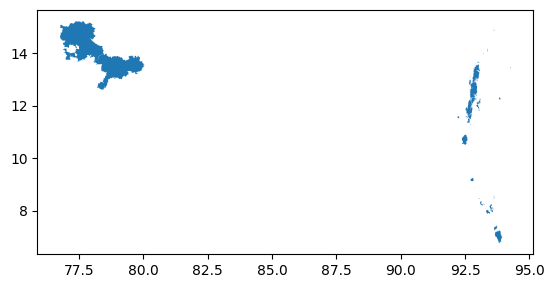

In [36]:
os.listdir(shp_folder)
# gdf = gpd.read_file(shpfiles[0])
gdf = gpd.read_file(shpfiles[0]).iloc[:5]
gdf.plot()

In [37]:
def gdfmask(gdf, raster_path, all_touched=True):
  """ returns a raster mask of the gdf
  
  Parameters
    ----------
    gdf : geopandasdataframe object
        Country
    raster : path to tiff raster
        Administration level

    Returns
    -------
    dictionary of geopandas dataframe's rasters with characteristics of given raster
  
  
  """
  
  with rasterio.open(raster_path) as src:
    # Read the raster data into a NumPy array
    raster_shape = src.read(1).shape
    raster_crs = src.crs
    raster_transform = src.transform

  gdf0 = gdf.to_crs(src.crs)
  gdf_masks = {}
  for index, row in gdf0.iterrows():
    # print(shapely_geometry)
    gdf_masks[index] = geometry_mask([mapping(row['geometry'])],
                                     out_shape=raster_shape,
                                     transform=raster_transform,
                                     all_touched=all_touched, 
                                     invert=True)
  return(gdf_masks)
gdfmask(gdf=gdf, raster_path = AEI)
gdfmask(gdf=gdf, raster_path = Area)

{0: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 1: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 2: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., F

In [38]:
mask0 = gdfmask(gdf=gdf, raster_path = AEI)
# mask0 = gdfmask(gdf=gdf, raster_path = Area)
mask0[0].sum(), mask0[0].shape, mask0[1].sum(), mask0[1].shape

(65, (2160, 4320), 97, (2160, 4320))

In [48]:
AEI
# gdal.Open(AEI, gdal.GA_ReadOnly).ReadAsArray()[mask0[3]]

'../data/Ras_shape_out/Rasters/AEI/AEI_10.tif'

In [40]:
# with rasterio.open(AEI) as src:
#     # Read the raster data into a NumPy array
#     r = AEI*int(mask0[4])


# r

In [41]:
# r[r > 0]

In [42]:
# def open_tiff_file(filepath):
#     with rasterio.open(filepath) as src:
#         array = src.read(1)
#         no_data_value = src.nodata
#         if no_data_value is not None:
#             array = np.where(array == no_data_value, 0, array)
#         yield array

In [70]:
np.unique(np.array(ranked_df.Crop.tolist()))

array(['Barley', 'Cassava', 'Cocoa', 'Coffee', 'Cotton', 'Fodder',
       'Groundnuts', 'Maize', 'Millet', 'Oil palm', 'Others annual1',
       'Others annual2', 'Others annual3', 'Others perennial', 'Potatoes',
       'Pulses', 'Rapeseed', 'Rice1', 'Rice2', 'Rice3', 'Sorghum',
       'Soybeans', 'Sugar beet', 'Sugar cane', 'Sunflower', 'Wheat1',
       'Wheat2'], dtype='<U16')

In [19]:
def step0(step, ranked_df, df_tot_st1, listcom, r_s, c_s, 
          dist_array, AH_array, AD_step1, ATS_2, AD_area1, i, df_mon, TAD_12=0):
  #$$$$$$$$
  #$$$$$$$$
  # (Filter the total dataframe for a month in which crop grow)
  # Get the months between planting and Maturity for the crop
  if not step in [1]:
      # Dataframe with the AEI left from the previous step for each month for the
      df_max_filt = df_tot_st1[df_tot_st1["Month"].isin(listcom)]
      
      # Group the cell values
      # 
      n = len(df_max_filt) // (r_s * c_s)
  
  
  # Select the maximum total area assigned for the month in which this crop grow
  df_max = df_max_filt.groupby(np.arange(len(df_max_filt)) // n).max()
  
  # Change it to array
  max_step2 = np.array(df_max["Total_st1"]).reshape(r_s, c_s) # "Total_st" + step

 #################################
  # if step in ["6"]:
  ##Detrmine the free AEI cell
  # if ranked_df_rf["Crop"][i_rf] in Annual:
  #   AEI_fr_ce_6 = np.where(dist_array["dist_array_aei"] > max_step6, (dist_array["dist_array_aei"]-max_step6), 0)
  #   Pot_ATS5=Pot_ATS6=np.where(dist_array["dist_array_cle"]>0,(AEI_fr_ce_6), 0)
  # else:
  #   area_95_=0.95*dist_array["dist_array_area"]
  #   free_area_95=np.where(area_95_> max_step6, (area_95_-max_step6), 0)
  #   Pot_ATS6=np.where(dist_array["dist_array_cle"]>dist_array["dist_array_aei"],(free_area_95), 0)
 #################################
  
  AEI_fr_ce_2 = np.where(dist_array["dist_array_aei"] > max_step2, 
                         (dist_array["dist_array_aei"]-max_step2), 0)
 ################
 # if step in ["3", "4"]:
 # AEI_fr_ce_3 = np.maximum(dist_array["dist_array_aei"] - max_step3, 0)
 ################
  
  # Determine the AH_free_cell
  AH_fr_ce_2 = np.maximum(AH_array - AD_step1, 0)
  
  # Potential area to be distributed in this step
  Pot_ATS2 = np.minimum(AEI_fr_ce_2, AH_fr_ce_2)

 #########
 # if step == 3:
 # Pot_ATS3 = np.where(dist_array["dist_array_cle"]>0,(AEI_fr_ce_3), 0)
 #########
 #########
 # if step == 4:
 # Pot_ATS4 = np.where(dist_array["dist_array_cle"] == 0, AEI_fr_ce_4, 0)
 #########
 #########
 # if step == "5":
 # ATS_5=ranked_df_rf.Growing_area[i_rf]
 # CE_fr_ce_5 = np.where(dist_array["dist_array_cle"] > max_step5, 
 #                       (dist_array["dist_array_cle"]-max_step5), 0)
 # Pot_ATS5=CE_fr_ce_5 if ATS_5 in Annual else np.where(dist_array["dist_array_cle"] > \
 #                                                      dist_array["dist_array_aei"],
 #                                                      (CE_fr_ce_5), 0)
 #########
  ############################
  # if step == 7:
  ##Detrmine the 95% of cell area
  # area_95_=0.95*dist_array["dist_array_area"]
  # free_area_95=np.where(area_95_> max_step7, (area_95_-max_step7), 0)

  # Pot_ATS7=np.where(((dist_array["dist_array_cle"]>0)|(dist_array["dist_array_aei"]>0)),
  #                   (free_area_95), 0)
  #################################
              
  # Determine the distribution ratio as the ratio of ATS and Pot_ATS
  with np.errstate(divide='ignore'):
    AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
    
  AD_area2= Pot_ATS2*AD_ra2 if ATS_2>0 else 0
  TAD_12=TAD_12 + AD_area1 + AD_area2
 #########
 # if step == 3:
 # TAD_13=AD_area1+AD_area2+AD_area3
 #########
 #########
 # if step == 4:
 # TAD_14=AD_area1+AD_area2+AD_area3+AD_area4
 #########
 #########
 # if step == "5":
 # AD_area5=Pot_ATS5*AD_ra5
 # TAD_5=AD_area5
 #########
 #########
 # if step == 6:
 # TAD_56=AD_area5+AD_area6 if ATS_6>0 else AD_area5
 #########

  #########################
  # Can it be done in Numpy or pandas
  ########################
  for row in range(TAD_12.shape[0]):
    for col in range(TAD_12.shape[1]):
      if TAD_12[row, col] <= dist_array["dist_array_area"][row, col]:
        TAD_12[row, col] = TAD_12[row, col]
      else:
        ratio = dist_array["dist_array_area"][row, col] / TAD_12[row, col]
        TAD_12[row, col] *= ratio
  
  if round(np.sum(TAD_12),2) <= (ranked_df.Growing_area[i]):
    ATS_3= (ranked_df.Growing_area[i])-round(np.sum(TAD_12),2)
    AD_step2=TAD_12
    ###
    # if step == 4 and (round(np.sum(TAD_14),2) < (ranked_df.Growing_area[i])):
    #   raise SyntaxError("Error Check Your Code!")
        # print("Iteration completed ")
    ########
    
  else:
    rGai = ranked_df.Growing_area[i]
    AD_area2= AD_area2*0 if rGai == 0 else TAD_12*(rGai /np.sum(TAD_12)) if rGai > 0 else AD_area2
    ATS_3= 0
    
  # Create array for step 2
  ###
  # if step == 3:
  # step = "3"
  ########
  array_name2 = "Array_" + ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "2" #+ step 
  arr2 = TAD_12

  # Repeat array for 12 months
  arr2_re = np.repeat(arr2, 12)
  #########################################
  # if step == "5":
  #Change the array to dataframe
  # c_s = len(arr2[0])
  # r_s = len(arr2)
  # df_month = pd.DataFrame(np.arange(1, 13), columns=['Month'])
  # df_mon = pd.concat([df_month] * c_s * r_s, ignore_index=True)
  #########################################
  # Convert array to dataframe
  df_2 = pd.DataFrame(arr2_re, index=np.arange(len(df_mon)), columns=[array_name2])
    
  # Merge month and array dataframes
  df_area2 = pd.concat([df_mon, df_2], axis=1)
    
  # Filter the months when the crop grows
  crop_1 = df_area2[(df_area2["Month"].isin(listcom))]
    
  # Filter the months when the crop doesn't grow
  crop_not = df_area2[(~df_area2["Month"].isin(listcom))]
    
  # Set the value of the array to 0 for months when the crop doesn't grow
  crop_not[array_name2].values[:] = 0

  ###
  # if step in ["5", "7"]:
  # for col in crop_not.columns:
  #   crop_not[array_name7].values[:] = 0
  ########
    
  # Concatenate the two dataframes and sort by index
  #####################################################
  # UNNESSESARY LINE
  df_name2 = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "_step2" #  + "_step" + step
  #####################################################
  df_name2 = pd.concat([crop_1, crop_not])
  df_name2 = df_name2.sort_index()
    
  # Add the dataframe to the list
  df_list = []
  df_list.append(df_name2[array_name2])
    
  # Concatenate all the dataframes in the list into a single array
  Step_2 = pd.concat(df_list, axis=1).sum(axis=1)
    ###
  # if step == 7:
  # Step_7 = Step_6 + pd.concat(df_list, axis=1).sum(axis=1)
  ########  
  ###########
  # if step == "4":
    # step4_finalarray(ranked_df, df_mon, Step_4, irri_totals, tiff_ir, 
    #                listcom, r_s, c_s, output_folder, i)
  ########
              
  
              
  # Create a dataframe from the final array
  df_tot_st2 = pd.concat([df_mon, Step_2], axis=1)
  df_tot_st2.columns = ['Month', 'Total_st2']
  # print("Total Step2:", df_tot_st2.head(24))
  return({"df_tot_st2":df_tot_st2, "dist_array":dist_array, 
            "AH_array":AH_array, "AD_step1":AD_step1, 
            "ATS_2":ATS_2, "AD_area1":AD_area1, "TAD_13":TAD_13})


In [117]:
def step00(step, ranked_df_rank, dist_array, AH_array, AD_area,
           df_mon=None, df_tot = None, TAD_12=None, df_cumulative=None, ATS_2=None):

  p = ranked_df_rank.Planting_Month.tolist()[0]
  m = ranked_df_rank.Maturity_Month.tolist()[0]
  listcom = getListcom(p, m)

  # CALCULATE AD
  AD_step1 = np.where(dist_array["dist_array_ara"] > 0,
                      (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)

  print("####")
  print(ranked_df_rank.Subcrop)
  print("####")
  if ranked_df_rank.Subcrop.tolist()[0] > 1: AD_step1 = AD_step1/ranked_df_rank.Subcrop.tolist()[0] 

  if round(np.sum(AD_step1),2) <= (ranked_df_rank.Growing_area.tolist()[0]):
    ATS_2= (ranked_df_rank.Growing_area.tolist()[0])-round(np.sum(AD_step1),2)
    AD_area=AD_step1
    print("Area distributed after step1:", round(np.sum(AD_step1),2))
    print("Iteration continues")
    if round(np.sum(AD_step1),2)==(ranked_df_rank.Growing_area.tolist()[0]):
      print("Area to be distributed in next step:", ATS_2)
      print("Iteration completed ")
  
  else:
    ATS_2= 0
    if ranked_df_rank.Growing_area.tolist()[0] >0:
        print("Error check your code!")
        print("More area available than the growing area")
        ratio= ranked_df_rank.Growing_area.tolist()[0]/np.sum(AD_step1)
    #                             print(ratio)
        AD_area=AD_step1*ratio
        print("Iteration completed")
        print("Area distributed in step1:",round( np.sum(AD_area),2))
    if ranked_df_rank.Growing_area.tolist()[0]== 0:
        AD_area=AD_step1*0
        print("No area will be distributed in step1 (Zero harvested area)")
        
 
  # Call the array to be distributed in step1 and convert it to dataframe
  array_name = "Array_" + ranked_df.Crop.tolist()[0][:3] + ranked_df.Crop.tolist()[0][-1] + "1"

  # Call the array (area) to be distributed monthly
  arr1 = AD_area
  arr1_re = np.repeat(arr1, 12)
  c_s = len(arr1[0])
  r_s = len(arr1)
    
  # Create a new dataframe in which we will iterate each cell value for each month according to the crop calendar
  #             crop_sum = 0
  df_month = pd.DataFrame(np.arange(1, 13), columns=['Month'])
  df_mon = pd.concat([df_month] * c_s * r_s, ignore_index=True)
    
  # Change the array to dataframe
  df_1 = pd.DataFrame(arr1_re, index=np.arange(len(df_mon)), columns=[array_name])
  # Merge the month and array dataframe
  df_area1 = pd.concat([df_mon, df_1], axis=1)
  # Filter the month in which the crop grows according to the crop calendar
  crop_1 = df_area1[(df_area1["Month"].isin(listcom))]
  # Filter the month in which the crop didn't grow according to the crop calendar
  crop_not = df_area1[(~df_area1["Month"].isin(listcom))]
  # Set the value of the array to 0 for months when the crop doesn't grow
  crop_not[array_name].values[:] = 0
  # Merge the two dataframes and sort it based on index
  df_name = ranked_df.Crop.tolist()[0][:3] + ranked_df.Crop.tolist()[0][-1] + "_step1"
  df_name = pd.concat([crop_1, crop_not])
  df_name = df_name.sort_index()
#             df_name = np.minimum(df_name, dist_array_aei)

    
  # Assign the area to be distributed in this step for each month according to crop calendar
  df_list = []
  df_list.append(df_name[array_name])

  Step_1 = pd.concat(df_list, axis=1).sum(axis=1)

  if df_cumulative is None:
    df_cumulative = pd.Series(np.zeros(len(Step_1)), index=Step_1.index)
#             if 'df_cumulative_st1' not in locals() or df_cumulative_st1.empty:
#                 df_cumulative_st1 = Step_1.copy()  
#             else:
    
  df_cumulative += Step_1
    
  df_tot = pd.concat([df_mon, df_cumulative], axis=1)
  df_tot.columns = ['Month', 'Total_st1']
    


    
  
  return {"df_cumulative":df_cumulative, "AD_area" : AD_area, 'df_mon':df_mon, "ATS_2": ATS_2, "df_tot":df_tot}

In [ ]:
allcrops = {'Barley':'Bar', 'Cassava':'Cas', 'Cotton':'Cot', 'Fodder':'Fod', 'Groundnuts':'Gro',
            'Maize':'Maz', 'Millet':'Mil', 'Oil palm':'Olp', 'Others annual':'Otha', 'Others perennial':'Othp',
            'Potatoes':'Pot', 'Pulses':'Pul', 'Rapeseed':'Rap', 'Rice':'Ric', 'Rye':'Rye', 'Sorghum':'Sor',
            'Soybeans':'Soy', 'Coffee':'Stm', 'Cocoa':'Stm', 'Sugar beet':'Sub', 'Sugar cane':'Sug', 'Sunflower':'Sun', 
            'Wheat':'Whe'}
dist_array = {}
irri_totals = {}

year = "00" # "05"


# GET ALL unique UNIT CODE
unit_codes = np.unique(np.array([os.path.splitext(os.path.basename(tiff_file))[0] for tiff_file in glob.glob("../{}/*/**.tif".format(root_folder), recursive=True)]))

for unit_code in unit_codes:
  # Get the crop-specific rainfed growing area and crop calendar of the unit code district
  ranked_df_unitcode = ranked_df.loc[(ranked_df['unit_code'] == int(unit_code))]

  # SKIP UNIT CODES NOT IN RANKED DATA
  if not ranked_df_unitcode.shape[0]:
    # print("Unit code {} is not in ranked_df".format(unit_code))
    continue

  # LOAD THE AEI, ARA, AND CLE
  for aac in ["AEI", "Ara","CLE"]:
    tiff_file_aac = os.path.join("../{}".format(root_folder), "{}_{}".format(aac, year), "{}.tif".format(unit_code))
    print(tiff_file_aac)
    dist_array["dist_array_{}".format(aac.lower())] = gdal.Open(tiff_file_aac, gdal.GA_ReadOnly).ReadAsArray()
 
   # Loop through the crops by rank while allocating area in the seven steps
  for j in range(1, int(np.max(ranked_df_unitcode['rank']) + 1)):
    ranked_df_rank = ranked_df_unitcode.loc[(ranked_df_unitcode['rank'] == j)]
    print(ranked_df_rank)
    # Extract array data for crop type and assign to corresponding variable in crop_dict
    crop_name = ranked_df_rank.Crop.tolist()[0]
    print(0)
    print(unit_code)  
    print(1)

    # GET the TIFF FILE FOR THE CROP
    tiff_file = None
    for k in allcrops.keys():
      if k in crop_name:
        tiff_file = os.path.join("../{}".format(root_folder), "{}_{}".format(allcrops[k], year), "{}.tif".format(unit_code))
        # print("FOUND")
        break
    # SKIP THE ROW IF CROP NOT IN ALL CROPS
    if not tiff_file:
      # print("Crop {} is not in allcrops dictionary".format(crop_name))
      break
    print(tiff_file)

    
    AH_array = gdal.Open(tiff_file, gdal.GA_ReadOnly).ReadAsArray()
    # AD_step1 = np.where(dist_array["dist_array_ara"] > 0,
    #                   (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
    # print(AD_step1)
    # break
  

      
    # CALL THE STEPS ONE AT A TIME WITH THE DATA  AND FIX THE ERRORS
    # step1 = step00(step=1, ranked_df = ranked_df_rank, df_tot_st1 = None, 
    #               listcom = listcom, r_s = None, c_s = None, 
    #               dist_array = dist_array, AH_array = AH_array,
    #               AD_step1 = AD_step1, ATS_2 = None, AD_area1 = None,
    #               i=None, df_mon=None, TAD_12=None)
    step1 = step00(step=1, ranked_df_rank = ranked_df_rank, dist_array = dist_array, AH_array = AH_array,
                   df_tot = None, ATS_2 = None, AD_area = None, df_cumulative=None,
                   df_mon=None, TAD_12=None)

      # {"df_cumulative":df_cumulative, "AD_area" : AD_area1, "ATS_2": ATS_2, "df_tot":df_tot}
    step2 = step00(step=2, ranked_df_rank = ranked_df_rank, dist_array = dist_array, AH_array = AH_array,
                  df_tot = step1['df_tot'],  ATS_2 = step1['ATS_2'], AD_area = step1['AD_area'], df_cumulative=step1['df_cumulative'], df_mon=step1['df_mon'], 
                  TAD_12=None)
    print(step1)


../data/Clipped_2000/AEI_00/3560001.tif
../data/Clipped_2000/Ara_00/3560001.tif
../data/Clipped_2000/CLE_00/3560001.tif
   rank Country                State District  unit_code    Crop  Subcrop  \
0     1   India  Andaman and Nicobar  Nicobar    3560001  Barley        1   

     Type  Growing_area  Planting_Month  Maturity_Month  
0  Annual             0               7              11  
0
3560001
1
../data/Clipped_2000/Bar_00/3560001.tif
####
0    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
Area to be distributed in next step: 0.0
Iteration completed 
####
0    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
Area to be distributed in next step: 0.0
Iteration completed 
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19915    0.0
19916    0.0
19917    0.0
19918    0.0
19919    0.0
Length: 19920, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0.,

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
30    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
102307    0.0
102308    0.0
102309    0.0
102310    0.0
102311    0.0
Length: 102312, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
102307      8
102308      9
102309     10
102310     11
102311     12

[102312 rows x 1 columns], 'ATS_2': inf, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3        0.0
3           4        0.0
4           5        0.0
...       ...        ...
102307      8        0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
34    2
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
####
34    2
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
102307    0.0
102308    0.0
102309    0.0
102310    0.0
102311    0.0
Length: 102312, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
102307      8
102308      9
102309     10
102310     11
102311     12

[102312 rows x 1 columns], 'ATS_2': 0, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
102307    0.0
102308    0.0
102309    0.0
102310    0.0
102311    0.0
Length: 102312, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
102307      8
102308      9
102309     10
102310     11
102311     12

[102312 rows x 1 columns], 'ATS_2': inf, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3        0.0
3           4        0.0
4           5        0.0
...       ...        ...
102307      8        0.0
102308      9        0.0
102309     10        0.0
102310     11        0.0
102311     12        0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
102307    0.0
102308    0.0
102309    0.0
102310    0.0
102311    0.0
Length: 102312, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
102307      8
102308      9
102309     10
102310     11
102311     12

[102312 rows x 1 columns], 'ATS_2': inf, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3        0.0
3           4        0.0
4           5        0.0
...       ...        ...
102307      8        0.0
102308      9        0.0
102309     10        0.0
102310     11        0.0
102311     12        0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29395    0.0
29396    0.0
29397    0.0
29398    0.0
29399    0.0
Length: 29400, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
29395      8
29396      9
29397     10
29398     11
29399     12

[29400 rows x 1 columns], 'ATS_2': 0.0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
29395      8        0.0
29396      9        0.0
29397     10        0.0
29398     11        0.0
29399     12        0.0

[29400 rows x 2 columns]}
    rank

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
63    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
####
63    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29395    0.0
29396    0.0
29397    0.0
29398    0.0
29399    0.0
Length: 29400, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
29395      8
29396      9
29397     10
29398     11
29399     12

[29400 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4       

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_3

####
66    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29395    0.0
29396    0.0
29397    0.0
29398    0.0
29399    0.0
Length: 29400, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
29395      8
29396      9
29397     10
29398     11
29399     12

[29400 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
29395      8        0.0
29396      9        0.0
29397 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
68    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29395    0.0
29396    0.0
29397    0.0
29398    0.0
29399    0.0
Length: 29400, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
29395      8
29396      9
29397     10
29398     11
29399     12

[29400 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
29395      8        0.0
29396      9        0.0
29397 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
75    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29395    0.0
29396    0.0
29397    0.0
29398    0.0
29399    0.0
Length: 29400, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
29395      8
29396      9
29397     10
29398     11
29399     12

[29400 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
29395      8        0.0
29396      9        0.0
29397 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
43987    0.0
43988    0.0
43989    0.0
43990    0.0
43991    0.0
Length: 43992, dtype: float64, 'AD_area': array([[ 0.      ,  0.      ,  0.      , ..., 17.382244,  8.541121,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 49.947796,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
43987      8
43988      9
43989     10
43990     11
43991     12

[43992 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
84    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 1581.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
43987    0.0
43988    0.0
43989    0.0
43990    0.0
43991    0.0
Length: 43992, dtype: float64, 'AD_area': array([[0.        , 0.        , 0.        , ..., 0.7670376 , 0.26720715,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.432365  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), 'df_mon':        Month
0          1
1  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
88    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
43987    0.0
43988    0.0
43989    0.0
43990    0.0
43991    0.0
Length: 43992, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
43987      8
43988      9
43989     10
43990     11
43991     12

[43992 rows x 1 columns], 'ATS_2': 83.0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
43987      8        0.0
43988      9        0.0
43989 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_3

####
101    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
43987    0.0
43988    0.0
43989    0.0
43990    0.0
43991    0.0
Length: 43992, dtype: float64, 'AD_area': array([[0.       , 0.       , 0.       , ..., 2.9188242, 1.4341716,
        0.       ],
       [0.       , 0.       , 0.       , ..., 9.13572  , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
43987      8
43988      9
43989     1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
112    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
112    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
28543    0.0
28544    0.0
28545    0.0
28546    0.0
28547    0.0
Length: 28548, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
28543      8
28544      9
28545     10
28546     11
28547     12

[28548 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
115    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
28543    0.0
28544    0.0
28545    0.0
28546    0.0
28547    0.0
Length: 28548, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
28543      8
28544      9
28545     10
28546     11
28547     12

[28548 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
28543      8        0.0
28544      9        0.0
28545

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
117    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
28543    0.0
28544    0.0
28545    0.0
28546    0.0
28547    0.0
Length: 28548, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
28543      8
28544      9
28545     10
28546     11
28547     12

[28548 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
28543      8        0.0
28544      9        0.0
28545

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
133    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.21
Iteration continues
####
133    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.21
Iteration continues
{'df_cumulative': 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
103    0.0
104    0.0
105    0.0
106    0.0
107    0.0
Length: 108, dtype: float64, 'AD_area': array([[0.        , 0.        , 0.        ],
       [0.        , 0.20615405, 0.        ],
       [0.        , 0.        , 0.        ]], dtype=float32), 'df_mon':      Month
0        1
1        2
2        3
3        4
4        5
..     ...
103      8
104      9
105     10
106     11
107     12

[108 rows x 1 columns], 'ATS_2': 26905.790000006557, 'df_tot':      Month  Total_st1
0        1        0.0
1        2        0.0
2        3        0.0
3        4        0.0
4        5        0.0
..     ...        ...
103      8        0.0
104      9        0.0
105     10        0.0
106     11        0.0
107     12       

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
148    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 4.0
####
148    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 4.0
{'df_cumulative': 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
103    0.0
104    0.0
105    0.0
106    0.0
107    0.0
Length: 108, dtype: float64, 'AD_area': array([[0., 0., 0.],
       [0., 4., 0.],
       [0., 0., 0.]], dtype=float32), 'df_mon':      Month
0        1
1        2
2        3
3        4
4        5
..     ...
103      8
104      9
105     10
106     11
107     12

[108 rows x 1 columns], 'ATS_2': 0, 'df_tot':      Month  Total_st1
0        1        0.0
1        2        0.0
2        3        0.0
3        4        0.0
4        5        0.0
..     ...        ...
103      8        0.0
104      9        0.0
105     10        0.0
106   

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
159    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48043    0.0
48044    0.0
48045    0.0
48046    0.0
48047    0.0
Length: 48048, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
48043      8
48044      9
48045     10
48046     11
48047     12

[48048 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
48043      8        0.0
48044      9        0.0
48045

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48043    0.0
48044    0.0
48045    0.0
48046    0.0
48047    0.0
Length: 48048, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
48043      8
48044      9
48045     10
48046     11
48047     12

[48048 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
48043      8        0.0
48044      9        0.0
48045     10        0.0
48046     11        0.0
48047     12        0.0

[48048 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48043    0.0
48044    0.0
48045    0.0
48046    0.0
48047    0.0
Length: 48048, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
48043      8
48044      9
48045     10
48046     11
48047     12

[48048 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
48043      8        0.0
48044      9        0.0
48045     10        0.0
48046     11        0.0
48047     12        0.0

[48048 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48043    0.0
48044    0.0
48045    0.0
48046    0.0
48047    0.0
Length: 48048, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
48043      8
48044      9
48045     10
48046     11
48047     12

[48048 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
48043      8        0.0
48044      9        0.0
48045     10        0.0
48046     11        0.0
48047     12        0.0

[48048 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
177    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48043    0.0
48044    0.0
48045    0.0
48046    0.0
48047    0.0
Length: 48048, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
48043      8
48044      9
48045     10
48046     11
48047     12

[48048 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
48043      8        0.0
48044      9        0.0
48045

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48043    0.0
48044    0.0
48045    0.0
48046    0.0
48047    0.0
Length: 48048, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
48043      8
48044      9
48045     10
48046     11
48047     12

[48048 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
48043      8        0.0
48044      9        0.0
48045     10        0.0
48046     11        0.0
48047     12        0.0

[48048 rows x 2 columns]}
     rank 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
212    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
Area to be distributed in next step: 0.0
Iteration completed 
####
212    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
Area to be distributed in next step: 0.0
Iteration completed 
{'df_cumulative': 0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
67    0.0
68    0.0
69    0.0
70    0.0
71    0.0
Length: 72, dtype: float64, 'AD_area': array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), 'df_mon':     Month
0       1
1       2
2       3
3       4
4       5
..    ...
67      8
68      9
69     10
70     11
71     12

[72 rows x 1 columns], 'ATS_2': 0.0, 'df_tot':     Month  Total_st1
0       1        0.0
1       2        0.0
2       3        0.0
3       4        0.0
4       5        0.0
..    ...        ...
67      8        0.0
68      9        0.0
69     10        0.0
70     11        0.0
71     12        0.0

[72 rows x 2 colu

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
255    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
####
255    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
583    0.0
584    0.0
585    0.0
586    0.0
587    0.0
Length: 588, dtype: float64, 'AD_area': array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32), 'df_mon':      Month
0        1
1        2
2        3
3        4
4        5
..     ...
583      8
584      9
585     10
586     11
587     12

[588 rows x 1 columns], 'ATS_2': 0, 'df_tot':      Month  Total_st1
0        1        0.0
1        2        0.0
2        3        0.0
3        4        0.0
4        5        0.0
..     ...  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
267    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 771.35
Iteration continues
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1291    0.0
1292    0.0
1293    0.0
1294    0.0
1295    0.0
Length: 1296, dtype: float64, 'AD_area': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.01854782e+01,  5.56074944e+01,  1.27256363e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.66663055e+01,  1.00519424e+02,
         5.91684875e+01,  0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  7.41168880e+00,  3.40126266e+01,
         3.40191002e+01,  5.84680901e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
279    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
Area to be distributed in next step: 0.0
Iteration completed 
####
279    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.0
Iteration continues
Area to be distributed in next step: 0.0
Iteration completed 
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1291    0.0
1292    0.0
1293    0.0
1294    0.0
1295    0.0
Length: 1296, dtype: float64, 'AD_area': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51739    0.0
51740    0.0
51741    0.0
51742    0.0
51743    0.0
Length: 51744, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
51739      8
51740      9
51741     10
51742     11
51743     12

[51744 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
51739      8        0.0
51740      9        0.0
51741     10        0.0
51742     11        0.0
51743     12        0.0

[51744 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
291    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
291    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51739    0.0
51740    0.0
51741    0.0
51742    0.0
51743    0.0
Length: 51744, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
51739      8
51740      9
51741     10
51742     11
51743     12

[51744 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
298    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 58.0
####
298    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 58.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51739    0.0
51740    0.0
51741    0.0
51742    0.0
51743    0.0
Length: 51744, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
51739      8
51740      9
51741     10
51742     11
51743     12

[51744 rows x 1 columns], 'ATS_2': 0, 'df_tot

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
300    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
300    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51739    0.0
51740    0.0
51741    0.0
51742    0.0
51743    0.0
Length: 51744, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
51739      8
51740      9
51741     10
51742     11
51743     12

[51744 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
310    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51739    0.0
51740    0.0
51741    0.0
51742    0.0
51743    0.0
Length: 51744, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
51739      8
51740      9
51741     10
51742     11
51743     12

[51744 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
51739      8        0.0
51740      9        0.0
51741

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
320    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 2182.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18715    0.0
18716    0.0
18717    0.0
18718    0.0
18719    0.0
Length: 18720, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
18715      8
18716      9
18717     10
18718     11
18719     12

[18720 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...   

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18715    0.0
18716    0.0
18717    0.0
18718    0.0
18719    0.0
Length: 18720, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
18715      8
18716      9
18717     10
18718     11
18719     12

[18720 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
18715      8        0.0
18716      9        0.0
18717     10        0.0
18718     11        0.0
18719     12        0.0

[18720 rows x 2 columns]}
     rank 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
337    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18715    0.0
18716    0.0
18717    0.0
18718    0.0
18719    0.0
Length: 18720, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
18715      8
18716      9
18717     10
18718     11
18719     12

[18720 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
18715      8        0.0
18716      9        0.0
187

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17215    0.0
17216    0.0
17217    0.0
17218    0.0
17219    0.0
Length: 17220, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
17215      8
17216      9
17217     10
17218     11
17219     12

[17220 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
17215      8        0.0
17216      9        0.0
17217     10        0.0
17218     11        0.0
17219     12        0.0

[17220 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17215    0.0
17216    0.0
17217    0.0
17218    0.0
17219    0.0
Length: 17220, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
17215      8
17216      9
17217     10
17218     11
17219     12

[17220 rows x 1 columns], 'ATS_2': 9.0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
17215      8        0.0
17216      9        0.0
17217     10        0.0
17218     11        0.0
17219     12        0.0

[17220 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_3

{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17215    0.0
17216    0.0
17217    0.0
17218    0.0
17219    0.0
Length: 17220, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
17215      8
17216      9
17217     10
17218     11
17219     12

[17220 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
17215      8        0.0
17216      9        0.0
17217     10        0.0
17218     11        0.0
17219     12        0.0

[17220 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
366    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
33595    0.0
33596    0.0
33597    0.0
33598    0.0
33599    0.0
Length: 33600, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
33595      8
33596      9
33597     10
33598     11
33599     12

[33600 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
33595      8        0.0
33596      9        0.0
33597

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
369    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
33595    0.0
33596    0.0
33597    0.0
33598    0.0
33599    0.0
Length: 33600, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
33595      8
33596      9
33597     10
33598     11
33599     12

[33600 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
33595      8        0.0
33596      9        0.0
33597

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
385    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
33595    0.0
33596    0.0
33597    0.0
33598    0.0
33599    0.0
Length: 33600, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
33595      8
33596      9
33597     10
33598     11
33599     12

[33600 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
33595      8        0.0
33596      9        0.0
33597

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
33595    0.0
33596    0.0
33597    0.0
33598    0.0
33599    0.0
Length: 33600, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
33595      8
33596      9
33597     10
33598     11
33599     12

[33600 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
33595      8        0.0
33596      9        0.0
33597     10        0.0
33598     11        0.0
33599     12        0.0

[33600 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
33595    0.0
33596    0.0
33597    0.0
33598    0.0
33599    0.0
Length: 33600, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
33595      8
33596      9
33597     10
33598     11
33599     12

[33600 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
33595      8        0.0
33596      9        0.0
33597     10        0.0
33598     11        0.0
33599     12        0.0

[33600 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
400    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 133.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
27547    0.0
27548    0.0
27549    0.0
27550    0.0
27551    0.0
Length: 27552, dtype: float64, 'AD_area': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04727324, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), 'df_mon':        Month
0          1
1  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
414    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
27547    0.0
27548    0.0
27549    0.0
27550    0.0
27551    0.0
Length: 27552, dtype: float64, 'AD_area': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 6.0977917, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
27547      8
27548      9
27549     1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
420    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 10263.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
54775    0.0
54776    0.0
54777    0.0
54778    0.0
54779    0.0
Length: 54780, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
54775      8
54776      9
54777     10
54778     11
54779     12

[54780 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
423    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
54775    0.0
54776    0.0
54777    0.0
54778    0.0
54779    0.0
Length: 54780, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
54775      8
54776      9
54777     10
54778     11
54779     12

[54780 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
54775      8        0.0
54776      9        0.0
54777

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
54775    0.0
54776    0.0
54777    0.0
54778    0.0
54779    0.0
Length: 54780, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
54775      8
54776      9
54777     10
54778     11
54779     12

[54780 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
54775      8        0.0
54776      9        0.0
54777     10        0.0
54778     11        0.0
54779     12        0.0

[54780 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
441    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
54775    0.0
54776    0.0
54777    0.0
54778    0.0
54779    0.0
Length: 54780, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
54775      8
54776      9
54777     10
54778     11
54779     12

[54780 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
54775      8        0.0
54776      9        0.0
547

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20455    0.0
20456    0.0
20457    0.0
20458    0.0
20459    0.0
Length: 20460, dtype: float64, 'AD_area': array([[ 0.      , 21.530802,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 23.05256 , 17.136818, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 20.6014  , 29.613646, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
20455      8
20456      9
20457     10
20458     11
20459     12

[20460 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
450    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 753.21
Iteration continues
####
450    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 753.21
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20455    0.0
20456    0.0
20457    0.0
20458    0.0
20459    0.0
Length: 20460, dtype: float64, 'AD_area': array([[ 0.      , 17.970991,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 14.055904, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32), 'df_mon':        Month
0        

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20455    0.0
20456    0.0
20457    0.0
20458    0.0
20459    0.0
Length: 20460, dtype: float64, 'AD_area': array([[  0., -inf,   0., ...,   0.,   0.,   0.],
       [  0., -inf, -inf, ...,   0.,   0.,   0.],
       [  0., -inf, -inf, ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
20455      8
20456      9
20457     10
20458     11
20459     12

[20460 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
20455      8        0.0
20456      9        0.0
20457     10        0.0
20458     1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
455    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 0.61
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20455    0.0
20456    0.0
20457    0.0
20458    0.0
20459    0.0
Length: 20460, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
20455      8
20456      9
20457     10
20458     11
20459     12

[20460 rows x 1 columns], 'ATS_2': 42.389999985694885, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
20455      8        0.0
20456      9  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20455    0.0
20456    0.0
20457    0.0
20458    0.0
20459    0.0
Length: 20460, dtype: float64, 'AD_area': array([[ 0.      , 27.568636,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 30.851376, 19.719038, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 28.075253, 31.026049, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
20455      8
20456      9
20457     10
20458     11
20459     12

[20460 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
89035    0.0
89036    0.0
89037    0.0
89038    0.0
89039    0.0
Length: 89040, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
89035      8
89036      9
89037     10
89038     11
89039     12

[89040 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
89035      8        0.0
89036      9        0.0
89037     10        0.0
89038     11        0.0
89039     12        0.0

[89040 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
89035    0.0
89036    0.0
89037    0.0
89038    0.0
89039    0.0
Length: 89040, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
89035      8
89036      9
89037     10
89038     11
89039     12

[89040 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
89035      8        0.0
89036      9        0.0
89037     10        0.0
89038     11        0.0
89039     12        0.0

[89040 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
89035    0.0
89036    0.0
89037    0.0
89038    0.0
89039    0.0
Length: 89040, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
89035      8
89036      9
89037     10
89038     11
89039     12

[89040 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
89035      8        0.0
89036      9        0.0
89037     10        0.0
89038     11        0.0
89039     12        0.0

[89040 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
522    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
523    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745     10        0.0
95746     11        0.0
95747     12        0.0

[95748 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745     10        0.0
95746     11        0.0
95747     12        0.0

[95748 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745     10        0.0
95746     11        0.0
95747     12        0.0

[95748 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
542    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
543    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
544    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
95743    0.0
95744    0.0
95745    0.0
95746    0.0
95747    0.0
Length: 95748, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
95743      8
95744      9
95745     10
95746     11
95747     12

[95748 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
95743      8        0.0
95744      9        0.0
95745

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6067    0.0
6068    0.0
6069    0.0
6070    0.0
6071    0.0
Length: 6072, dtype: float64, 'AD_area': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
567    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6067    0.0
6068    0.0
6069    0.0
6070    0.0
6071    0.0
Length: 6072, dtype: float64, 'AD_area': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5767    0.0
5768    0.0
5769    0.0
5770    0.0
5771    0.0
Length: 5772, dtype: float64, 'AD_area': array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00,

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
590    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5767    0.0
5768    0.0
5769    0.0
5770    0.0
5771    0.0
Length: 5772, dtype: float64, 'AD_area': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0.,

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
607    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 32.17
Iteration continues
####
607    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 32.17
Iteration continues
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5755    0.0
5756    0.0
5757    0.0
5758    0.0
5759    0.0
Length: 5760, dtype: float64, 'AD_area': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
629    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 375.75
Iteration continues
####
629    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: 375.75
Iteration continues
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7195    0.0
7196    0.0
7197    0.0
7198    0.0
7199    0.0
Length: 7200, dtype: float64, 'AD_area': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,


/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
643    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 1.0
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7195    0.0
7196    0.0
7197    0.0
7198    0.0
7199    0.0
Length: 7200, dtype: float64, 'AD_area': array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
660    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 152.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
50107    0.0
50108    0.0
50109    0.0
50110    0.0
50111    0.0
Length: 50112, dtype: float64, 'AD_area': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.04079305, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04418902, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), 'df_mon':        Month
0          1
1  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
666    1
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 1.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
50107    0.0
50108    0.0
50109    0.0
50110    0.0
50111    0.0
Length: 50112, dtype: float64, 'AD_area': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00029138, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00036235, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), 'df_mon':        Month
0          1
1    

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
50107    0.0
50108    0.0
50109    0.0
50110    0.0
50111    0.0
Length: 50112, dtype: float64, 'AD_area': array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0., -inf, ...,   0.,   0.,   0.],
       [  0., -inf,  -0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
50107      8
50108      9
50109     10
50110     11
50111     12

[50112 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
50107      8        0.0
50108      9        0.0
50109     10        0.0
50110     1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
699    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
71827    0.0
71828    0.0
71829    0.0
71830    0.0
71831    0.0
Length: 71832, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
71827      8
71828      9
71829     10
71830     11
71831     12

[71832 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
71827      8        0.0
71828      9        0.0
71829

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
71827    0.0
71828    0.0
71829    0.0
71830    0.0
71831    0.0
Length: 71832, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
71827      8
71828      9
71829     10
71830     11
71831     12

[71832 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
71827      8        0.0
71828      9        0.0
71829     10        0.0
71830     11        0.0
71831     12        0.0

[71832 rows x 2 columns]}
     ran

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
716    1
Name: Subcrop, dtype: int64
####
No area will be distributed in step1 (Zero harvested area)
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16867    0.0
16868    0.0
16869    0.0
16870    0.0
16871    0.0
Length: 16872, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
16867      8
16868      9
16869     10
16870     11
16871     12

[16872 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
16867      8        0.0
16868      9        0.0
168

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
726    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
726    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16867    0.0
16868    0.0
16869    0.0
16870    0.0
16871    0.0
Length: 16872, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
16867      8
16868      9
16869     10
16870     11
16871     12

[16872 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
110419    0.0
110420    0.0
110421    0.0
110422    0.0
110423    0.0
Length: 110424, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
110419      8
110420      9
110421     10
110422     11
110423     12

[110424 rows x 1 columns], 'ATS_2': inf, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3        0.0
3           4        0.0
4           5        0.0
...       ...        ...
110419      8        0.0
110420      9        0.0
110421     10        0.0
110422     11        0.0
110423     12        0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
110419    0.0
110420    0.0
110421    0.0
110422    0.0
110423    0.0
Length: 110424, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
110419      8
110420      9
110421     10
110422     11
110423     12

[110424 rows x 1 columns], 'ATS_2': inf, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3        0.0
3           4        0.0
4           5        0.0
...       ...        ...
110419      8        0.0
110420      9        0.0
110421     10        0.0
110422     11        0.0
110423     12        0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
110419    0.0
110420    0.0
110421    0.0
110422    0.0
110423    0.0
Length: 110424, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':         Month
0           1
1           2
2           3
3           4
4           5
...       ...
110419      8
110420      9
110421     10
110422     11
110423     12

[110424 rows x 1 columns], 'ATS_2': inf, 'df_tot':         Month  Total_st1
0           1        0.0
1           2        0.0
2           3        0.0
3           4        0.0
4           5        0.0
...       ...        ...
110419      8        0.0
110420      9        0.0
110421     10        0.0
110422     11        0.0
110423     12        0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
756    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
756    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
Length: 2016, dtype: float64, 'AD_area': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -0.0000000e+00,           -inf,
                  -inf,           -inf,  2.3931287e-02,           -inf,
        -0.0000000e+00, -0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
772    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
772    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
Length: 2016, dtype: float64, 'AD_area': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -0.0000000e+00,           -inf,
                  -inf,           -inf,  5.0853986e-02,           -inf,
        -0.0000000e+00, -0.

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


../data/Clipped_2000/Ara_00/3560031.tif
../data/Clipped_2000/CLE_00/3560031.tif
     rank Country              State    District  unit_code   Crop  Subcrop  \
780     1   India  Arunachal Pradesh  East Siang    3560031  Rice2        2   

       Type  Growing_area  Planting_Month  Maturity_Month  
780  Annual          5812              11               3  
0
3560031
1
../data/Clipped_2000/Ric_00/3560031.tif
####
780    2
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 5812.0
####
780    2
Name: Subcrop, dtype: int64
####
Error check your code!
More area available than the growing area
Iteration completed
Area distributed in step1: 5812.0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
40999    0.0
41000    0.0
41001    0.0
41002    0.0
41003    0.0
Length: 41004, dtype: float64, 'AD_area': array([[ 0.      ,  0.      ,  0.      , ...,  0.     

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
789    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
40999    0.0
41000    0.0
41001    0.0
41002    0.0
41003    0.0
Length: 41004, dtype: float64, 'AD_area': array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 28.533066,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 78.71323 , 39.59556 ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
40999      8
41000      9
41001     1

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
40999    0.0
41000    0.0
41001    0.0
41002    0.0
41003    0.0
Length: 41004, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
40999      8
41000      9
41001     10
41002     11
41003     12

[41004 rows x 1 columns], 'ATS_2': 0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
40999      8        0.0
41000      9        0.0
41001     10        0.0
41002     11        0.0
41003     12        0.0

[41004 rows x 2 columns]}
     rank 

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
804    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
40999    0.0
41000    0.0
41001    0.0
41002    0.0
41003    0.0
Length: 41004, dtype: float64, 'AD_area': array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., -inf,   0.,   0.],
       [  0.,   0.,   0., ..., -inf, -inf,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
40999      8
41000      9
41001     10
41002     11
41003     12

[41004 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...  

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
817    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
####
817    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3595    0.0
3596    0.0
3597    0.0
3598    0.0
3599    0.0
Length: 3600, dtype: float64, 'AD_area': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
840    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
86263    0.0
86264    0.0
86265    0.0
86266    0.0
86267    0.0
Length: 86268, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
86263      8
86264      9
86265     10
86266     11
86267     12

[86268 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
86263      8        0.0
86264      9        0.0
86265

/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
/tmp/ipykernel_381/480240178.py:10: RuntimeWarning: overflow encountered in multiply
  (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)


####
843    1
Name: Subcrop, dtype: int64
####
Area distributed after step1: -inf
Iteration continues
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
86263    0.0
86264    0.0
86265    0.0
86266    0.0
86267    0.0
Length: 86268, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
86263      8
86264      9
86265     10
86266     11
86267     12

[86268 rows x 1 columns], 'ATS_2': inf, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
86263      8        0.0
86264      9        0.0
86265

In [93]:
root_folder

'data/Clipped_2000'

In [64]:
# Load the unit code files



tiff_files = glob.glob("../{}/*/*.tif".format(root_folder), recursive=True)  #glob.glob("{}/**/*.tif".format(raster_folder), recursive=True)  
allcrops = {"Rice":"Ric", "Wheat":"Whe"}
dist_array = {}
irri_totals = {}

year = "00" # "05"

# for unit_code in ranked_df['unit_code'].unique():
dist_array["dist_array_area"] = None
  # (Filter and extract TIFF files that correspond to the selected unit_code)



# for tiff_file in tiff_files: #[:2]
#   # print(tiff_file)
#   # Open the tiff file 
#   # 
#   folder_path = os.path.dirname(tiff_file)
#   main_folder_path, subfolder_name = os.path.split(folder_path)
#   print(subfolder_name ) 
  
#   if subfolder_name in ["AEI_{}".format(year), "Ara_{}".format(year),"CLE_{}".format(year)]:
#     print(subfolder_name )
#     next

#   # IF IT IS A CROP SUBFOLDER
#   if subfolder_name in ["{}_{}".format(ii, year)for ii in allcrops.values()]:
#     print(1)
#     print(subfolder_name )
#     next
    
  # # Get the Unit code from the tiff file: basename    
  # unit_code = os.path.splitext(os.path.basename(tiff_file))[0] 
  # # print(tiff_file)
  # # with open_tiff_file(tiff_file) as array:
  # #   print(array)
  # #   array = np.where(np.logical_or(np.isnan(array), np.isinf(array)), 0, array)
  # array = gdal.Open(tiff_file, gdal.GA_ReadOnly).ReadAsArray()
  # # if  array.sum():
  # #   print(array.sum())
  # # print(unit_code )
      
  #  # # Get the Unit code from the tiff file: basename    
  # # unit_code = os.path.splitext(os.path.basename(tiff_file))[0] 
  # #   # (#os.path.basename(tiff_file)[:-4])

  # #       #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$%%%%%%%%%%%%%%%%%^&^^^^^^^^^^^^^^

  # # # Get the crop-specific rainfed growing area and crop calendar of the unit code district
  # ranked_df_unitcode = ranked_df.loc[(ranked_df['unit_code'] == int(unit_code))]
  # # print(ranked_df_unitcode)
  #  # Loop through the crops by rank while allocating area in the seven steps
  # for j in range(1, int(np.max(ranked_df_unitcode['rank']) + 1)):
  #   ranked_df_rank = ranked_df_unitcode.loc[(ranked_df_unitcode['rank'] == j)]
  #   print(ranked_df_rank)

  #   # CAN WE MOVE THE "AEI_05" "Ara_05" AND "CLE_05" OPERATIONS TO A SEPARATE FUNCTION
  #     # WHAT ARE THE CONNECTIONS TO THE AREA SEPARATION
  #   for i, row in ranked_df_rank.iterrows():
  #     p = ranked_df_rank.Planting_Month[i]
  #     m = ranked_df_rank.Maturity_Month[i]
  #     listcom = getListcom(p, m)
  #     if subfolder_name == "AEI_05":
  #       tiff_ir = tiff_file
  #       dist_array["dist_array_aei"] = array
  #     elif subfolder_name == "Ara_05":
  #       dist_array["dist_array_area"] = array
  #     elif subfolder_name == "CLE_05":
  #       dist_array["dist_array_cle"] = array
      

        
  #     else:
  #       # Extract array data for crop type and assign to corresponding variable in crop_dict
  #       crop_name = ranked_df.Crop[i]
  #       dist_array[crop_name] = array
  #       AH_array = dist_array[crop_name]
  #       AD_step1 = np.where(dist_array["dist_array_area"] > 0,
  #                           (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_area"], 0)

    
  #     # CALL THE STEPS ONE ATA A TIME WITH THE DATA  AND FIX THE ERRORS
  #     step1 = step0(ranked_df = ranked_df_rank, df_tot_st1 = None, 
  #                   listcom = listcom, r_s = None, c_s = None, 
  #                   dist_array = dist_array, AH_array = AH_array, 
  #                   AD_step1 = AD_step1, ATS_2 = None, AD_area1 = None, 
  #                   i=i, df_mon=None, TAD_12=None)
  #     step1
      # ADDRESS ISSUE OF SEPARATE RAIFED AND IRRIGATED ALLOCATION

  # break

In [ ]:


    
  #   # CAN WE MOVE THE "AEI_05" "Ara_05" AND "CLE_05" OPERATIONS TO A SEPARATE FUNCTION
  #     # WHAT ARE THE CONNECTIONS TO THE AREA SEPARATION
  #   for i, row in ranked_df_rank.iterrows():
  #     p = ranked_df_rank.Planting_Month[i]
  #     m = ranked_df_rank.Maturity_Month[i]
  #     listcom = getListcom(p, m)
  #     if subfolder_name == "AEI_05":
  #       tiff_ir = tiff_file
  #       dist_array["dist_array_aei"] = array
  #     elif subfolder_name == "Ara_05":
  #       dist_array["dist_array_area"] = array
  #     elif subfolder_name == "CLE_05":
  #       dist_array["dist_array_cle"] = array
  #     else:
  #       # Extract array data for crop type and assign to corresponding variable in crop_dict
  #       crop_name = ranked_df.Crop[i]
  #       dist_array[crop_name] = array
  #       AH_array = dist_array[crop_name]
  #       AD_step1 = np.where(dist_array["dist_array_area"] > 0,
  #                           (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_area"], 0)
  #     # CALL THE STEPS ONE ATA A TIME WITH THE DATA  AND FIX THE ERRORS
  #     step1 = step0(ranked_df = ranked_df_rank, df_tot_st1 = None, 
  #                   listcom = listcom, r_s = None, c_s = None, 
  #                   dist_array = dist_array, AH_array = AH_array, 
  #                   AD_step1 = AD_step1, ATS_2 = None, AD_area1 = None, 
  #                   i=i, df_mon=None, TAD_12=None)
  #     step1
      # ADDRESS ISSUE OF SEPARATE RAIFED AND IRRIGATED ALLOCATION

In [ ]:
def step4_finalarray(ranked_df, df_mon, Step_4, unit_code,
                     irri_totals, tiff_ir, listcom, r_s, c_s, output_folder, i):
  # Create a dataframe from the final array
  for crop_ir in ranked_df['Crop'].unique():
    df_crop_ir = ranked_df[ranked_df['Crop'] == crop_ir]
    # df_tot_st4 = pd.concat([df_mon, pd.DataFrame(Step_4, columns=['Total_st4'], index=df_crop_ir.index)], axis=1)
    df_tot_st4 = pd.concat([df_mon, Step_4], axis=1)
    df_tot_st4.columns = ['Month', 'Total_st4']
    irri_totals[crop_ir] = df_tot_st4
    # print(np.sum(irri_totals[crop]))
    # print(np.sum(irri_totals[crop]))
    # print(df_tot_st4.head(24))
    with rasterio.open(tiff_ir) as src:
      xmin, ymin, xmax, ymax = src.bounds
      xres, yres = src.res
      pixel_width, pixel_height = src.res
      crs = src.crs

      for k in listcom:
        file_name = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + str(unit_code)+"_tot"
        df_max_filt4 = df_tot_st4[(df_tot_st4["Month"] == k)]
        arr_filenam = np.array(df_max_filt4["Total_st4"]).reshape(r_s, c_s)
        arr_filenam = np.where(np.logical_or(np.isnan(arr_filenam), np.isinf(arr_filenam)), 0, arr_filenam)
        arr_filenam = arr_filenam.astype(rasterio.float32)  # ensure data type is compatible with output GeoTIFF
        Ras_filena = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "_" + str(unit_code) + "_ir" + "_" + str(k)
        transform = rasterio.transform.from_origin(xmin, ymax, pixel_width, pixel_height)
        profile = {
          'driver': 'GTiff',
          'dtype': arr_filenam.dtype,
          'count': 1,
          'height': arr_filenam.shape[0],
          'width': arr_filenam.shape[1],
          'transform': transform,
          'crs': crs,
          'nodata': 0
        }
        
        with rasterio.open(os.path.join(output_folder, Ras_filena + '.tif'), 'w', **profile) as dst:
          dst.write(arr_filenam, 1)


In [ ]:
def rasteriosave7(ranked_df, tiff_ir, unit_code, listcom, output_folder):
  with rasterio.open(tiff_ir) as src:
    xmin, ymin, xmax, ymax = src.bounds
    xres, yres = src.res
    pixel_width, pixel_height = src.res
    crs = src.crs
      
    for k in listcom:
      file_name = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + str(unit_code)+"_tot"
      df_max_filt4 = df_tot_st4[(df_tot_st4["Month"] == k)]
      arr_filenam = np.array(df_max_filt4["Total_st4"]).reshape(r_s, c_s)
      arr_filenam = np.where(np.logical_or(np.isnan(arr_filenam), 
                                           np.isinf(arr_filenam)), 0, arr_filenam)
      arr_filenam = arr_filenam.astype(rasterio.float32)  # ensure data type is compatible with output GeoTIFF
      Ras_filena = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "_" + str(unit_code) + "_ir" + "_" + str(k)
      transform = rasterio.transform.from_origin(xmin, ymax, pixel_width, pixel_height)
      profile = {
          'driver': 'GTiff',
          'dtype': arr_filenam.dtype,
          'count': 1,
          'height': arr_filenam.shape[0],
          'width': arr_filenam.shape[1],
          'transform': transform,
          'crs': crs,
          'nodata': 0
        }
        
      with rasterio.open(os.path.join(output_folder, Ras_filena + '.tif'), 
                         'w', **profile) as dst:
          dst.write(arr_filenam, 1)